In [6]:
import numpy as np
import galois
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy import sparse
GF = galois.GF(2)

In [17]:
# H = np.loadtxt('./ccod/16_4_3.txt', dtype=np.int8)

In [18]:
# https://scialert.net/fulltext/?doi=tasr.2012.929.934
def girth(H, g):
    # girth can only be even in bipartite graphs
    combs = list(combinations(np.arange(H.shape[0]), g//2))
    for c in combs:
        w = np.zeros(H.shape[1])
        for r in range(g//2):
            w += np.array(H[c[r]])
        if (np.count_nonzero(w == 2) == g//2):
            return True
    return False

In [84]:
# configuration model
# https://en.wikipedia.org/wiki/Configuration_model

n = 12
deg_v = 3 # w_c. Every bit is in this many checks
deg_c = 4 # w_r. Every check has this many bits in it
num_checks = (n*deg_v)//deg_c
k = n - num_checks

vs = np.array([[j for i in range(deg_v)] for j in range(n)]).flatten()
cs = np.array([[j for i in range(deg_c)] for j in range(num_checks)]).flatten()

H = np.zeros((num_checks, n), dtype=bool)

while (vs.size and cs.size):
    # choose random 'stub' from each array
    double_edge = True
    while(double_edge):
        v_ind = np.random.randint(0, len(vs))
        c_ind = np.random.randint(0, len(cs))

        if (H[cs[c_ind]][vs[v_ind]] != 1):
            double_edge = False
            H[cs[c_ind]][vs[v_ind]] = 1
            # if (girth(H, 4)):
            #     H[cs[c_ind]][vs[v_ind]] = 0
            #     break
            vs = np.delete(vs, v_ind)
            cs =np.delete(cs, c_ind)
            
H = sparse.csc_matrix(H)



hx1 = sparse.kron(H, np.eye(H.shape[1], dtype=bool))
hx2 = sparse.kron(np.eye(H.shape[0], dtype=bool), H.T)
Hx = sparse.csr_matrix(sparse.hstack([hx1, hx2], ))

hz1 = sparse.kron(np.eye(H.shape[1], dtype=bool), H)
hz2 = sparse.kron(H.T, np.eye(H.shape[0], dtype=bool))
Hz = sparse.csr_matrix(sparse.hstack([hz1, hz2]))

In [86]:
H.toarray()*1

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]])

In [81]:
l = np.arange(Hx.shape[1])
combs = combinations(l,3)

for c in combs:
    e = GF(np.zeros(Hx.shape[1], dtype=np.int8))
    for qb in c:
        e[qb] = 1
    
    synd = Hx @ e
    mask = GF(np.zeros(Hx.shape[0], dtype=np.int8))
    mask[7] = 1

    if (np.array_equal(synd, mask)):
        print(c)
    else:
        continue

In [83]:
len(set(combinations(np.arange(400),3)))

10586800

In [ ]:
count = [[0 for _ in range(q_dc)] for _ in range(Hx.shape[0])]
rows = Hx.shape[0]
for j in range(rows):
    for i in range(rows):
        if (j != i):
            num_overlap = len(set(Hz[j].indices) & set(Hz[i].indices))
            count[j][num_overlap] += 1
# for i in range(rows):
#     num_overlap = len(set(Hx[0].indices) & set(Hz[i].indices))
#     count[num_overlap] += 1
print(count)

In [128]:
counts2 = []

for j in range(rows):
    count2 = set()
    for i in range(rows):
        if (i != j):
            if ((set(Hx[j].indices) & set(Hx[i].indices))):
                count2.add(i)
    counts2.append(count2)

In [132]:
lst = []
# for j in range(len(counts2)):
#     for i in range(len(counts2)):
#         if (i != j):
#             lst.append(len(counts2[j] & counts2[i]))

num = 6
for n in range(10000):
    ints = np.random.choice(np.arange(len(counts2)), size=num, replace=False)
    s = counts2[ints[0]]

    for i in range(1, num):
        s = s | counts2[ints[i]]

    if (len(s) == 17*num):
        lst.append(1)
print(len(lst))

2


In [81]:
count2 = np.array(count)
# count2 = count2/Hx.shape[0]
print(count2)

[[174  17   0 ...   0   0   0]
 [174  17   0 ...   0   0   0]
 [174  17   0 ...   0   0   0]
 ...
 [174  17   0 ...   0   0   0]
 [174  17   0 ...   0   0   0]
 [174  17   0 ...   0   0   0]]


In [47]:
count_avg = np.sum(count2, axis=0)/Hx.shape[0]
count_avg

array([0.94      , 0.05666667, 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [60]:
H = H.tocsr()
count = [[0 for _ in range(deg_c)] for _ in range(H.shape[0])]
rows = H.shape[0]
for j in range(rows):
    for i in range(rows):
        if (j != i):
            num_overlap = len(set(H[j].indices) & set(H[i].indices))
            count[j][num_overlap] += 1
# for i in range(rows):
#     num_overlap = len(set(Hx[0].indices) & set(Hz[i].indices))
#     count[num_overlap] += 1
print(count)

[[3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0], [3, 8, 0, 0]]


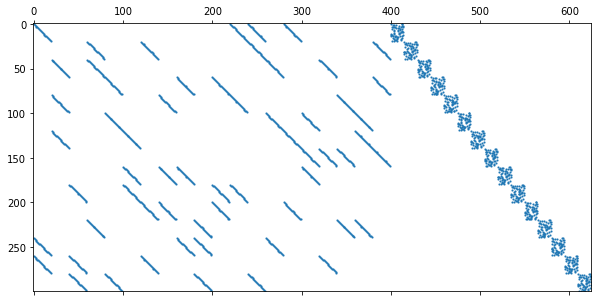

In [55]:
plt.figure(figsize=(10,5))
plt.spy(Hx, markersize=1)

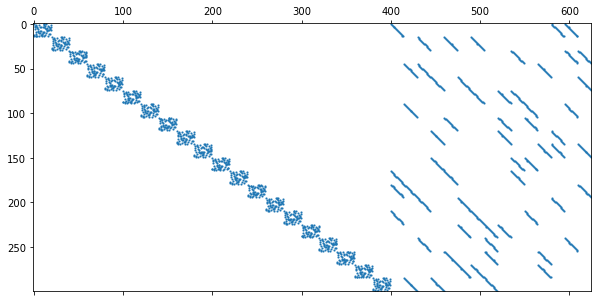

In [56]:
plt.figure(figsize=(10,5))
plt.spy(Hz, markersize=1)

In [78]:
inds = set(Hz[0].indices) | set(Hz[12].indices)
inds

{1, 6, 9, 11, 17, 22, 25, 27, 256, 268, 304, 340, 352, 364}

In [79]:
for i in range(Hz.shape[0]):
    print(set(Hz[i].indices) & inds)

{352, 1, 6, 9, 11, 268, 304}
{6}
{11}
{9}
set()
set()
set()
{1}
{11}
{1}
{6}
{9}
{256, 364, 17, 340, 22, 25, 27}
{22}
{27}
{25}
set()
set()
set()
{17}
{27}
{17}
{22}
{25}
{268}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{268, 340}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{340}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{304}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{256, 268}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{364}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{256}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{304, 364}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{256, 352}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{352}
set()
set()

In [38]:
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def syn_from_F(F, H):
    eF = GF(np.zeros(H.shape[1], dtype=np.int8))
    np.put(eF, F, [1])
    return set(np.where(H @ eF)[0])

Fx = [list(powerset(np.where(Hx[i])[0]))[1:] for i in range(Hx.shape[0])]
Fx = list(chain(*Fx)) # can take set of this list for slight reduction in size
# Fx = [set(g) for g in Fx] 
Fz = [list(powerset(np.where(Hz[i])[0]))[1:] for i in range(Hz.shape[0])]
Fz = list(chain(*Fz))
# Fz = [set(g) for g in Fz]

sigma_Fx = [syn_from_F(g, Hz) for g in Fx] # set of indices where syndrome is 1
sigma_Fz = [syn_from_F(g, Hx) for g in Fz]

In [39]:
def ssf(syn, x_z):
    # given a syndrome, syn: sigma_x or sigma_z 
    # x_z false for x stabilizers, true for z stabilizers
    s = set(np.where(syn.copy())[0])
    e = set()
    F = Fx if x_z else Fz
    sigma_F = sigma_Fx if x_z else sigma_Fz
    
    while True:
        max = -1
        max_gen = None
        max_sigma_gen = None
        for g, sigma_g in zip(F, sigma_F):
            s_i = s ^ sigma_g
            if (len(s_i) < len(s)):
                rel_weight = (len(s) - len(s_i)) / len(g)
                if (rel_weight > max):
                    max = rel_weight
                    max_gen = g
                    max_sigma_gen = sigma_g
            else:
                continue

        if (max == -1):
            if (len(s) == 0):
                return e
            else:
                return "FAIL"
        else:
            e = e ^ set(max_gen)
            s = s ^ max_sigma_gen

In [ ]:
p = 0.05

# how is this able to decode an error with more than (d-1)/2 errors?
sum = 0
num_iters = 100
for i in range(num_iters):
    eX = GF([1 if np.random.uniform() < p else 0 for i in range(Hx.shape[1])])
    # eZ = GF([1 if np.random.uniform() < p else 0 for i in range(Hz.shape[1])])

    sigma_eX = Hx @ eX.T
    # sigma_eZ = Hz @ eZ.T
    e1 = ssf(sigma_eX, False)
    # e2 = ssf(sigma_eZ, True)
    # print("X-error: ", np.where(eX)[0])
    # print(e1)
    if (set(np.where(eX)[0]) == e1):
        sum += 1

In [232]:
arr = np.array([1] * q_dc + [0] * (Hx.shape[1]-q_dc))
np.random.shuffle(arr)

random_count = [0 for _ in range(q_dc)]
for i in range(10000):
    arr2 = np.array([1] * q_dc + [0] * (Hx.shape[1]-q_dc))
    np.random.shuffle(arr2)

    num_overlap = np.count_nonzero(GF(arr) & GF(arr2))
    random_count[num_overlap] += 1

random_count

[9476, 511, 13, 0, 0, 0, 0]

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np

def hgd(N,K,n,k):
    return (math.comb(K,k) * math.comb(N-K,n-k)) / math.comb(N,n)

pmf = [hgd(Hx.shape[1],q_dc,q_dc,k) for k in range(q_dc)]
# pmf = [hgd(500,70,300,k) for k in range(60)]

print(pmf)
# plt.scatter(np.arange(60), pmf, label='hgd')

plt.scatter(np.arange(q_dc), pmf, label='hgd')
# plt.scatter(np.arange(q_dc), [x/Hx.shape[0] for x in count[2]], label='code')
plt.scatter(np.arange(q_dc), count_avg, label='code')

plt.scatter(np.arange(q_dc), [x/10000 for x in random_count], label='random')
plt.legend(loc='upper right')
plt.yscale('log')

NameError: name 'q_dc' is not defined

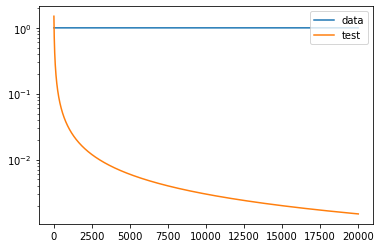

In [15]:
def prob(num_checks, deg_c, deg_v):
    prod = 1
    for i in range(1, deg_c):
        prod *= hgd(num_checks-1, deg_v*i-i, deg_v-1, 0)
    return prod

def prob2(num_checks, deg_c, deg_v, k):
    return hgd(num_checks,deg_c,deg_v,k)

# data = [1 - prob(i, deg_c, deg_v) for i in range(20, 20000)]
data = [1 - (hgd(i, 4, 3, 0) + hgd(i, 4, 3, 1))**i**2 for i in range(20, 20000)]
test = [30/i for i in range(20, 20000)]
plt.plot(np.arange(20,20000), data, label='data')
plt.plot(np.arange(20,20000), test, label='test')
plt.legend(loc='upper right')
plt.yscale('log')

In [2]:
a = [15.06, 17.05, 63.37]

for i in range(3):
    for j in range(3):
        print(a[i]-a[j])

0.0
-1.9900000000000002
-48.309999999999995
1.9900000000000002
0.0
-46.31999999999999
48.309999999999995
46.31999999999999
0.0


In [3]:
71.29- 99.85

-28.559999999999988

In [5]:
70.75- 81.7

-10.950000000000003